In [1]:

from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, det_curve

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def recursive_list_files(directory, extension=None):
    """
    Recursively list files in a directory
    :param directory: directory to list files from
    :param extension: file extension to filter by
    :return: list of files in directory
    """
    files = []
    for root, dirs, filenames in os.walk(directory, followlinks=True):
        for filename in filenames:
            if extension is None or filename.endswith(extension):
                files.append(os.path.join(root, filename))
    return files

In [2]:
acmccs_apr3_df = pd.read_csv("../traindata/ACMCCS/meta_apr3.csv")
acmccs_apr3_df.fillna("-", inplace=True)
acmccs_apr3_df = acmccs_apr3_df.astype(str)
acmccs_apr3_df['Source link'] = acmccs_apr3_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
acmccs_apr3_df


,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Speaker name,Gender,Age,label,Model,subset
0,Real/Korean_AIHUB/09MKIS0040/09MKIS0040_12815.wav,09MKIS0040_12815.wav,-,No,Korean,-,-,09MKIS0040_12815,AIHUB,09MKIS0040,Male,Adult,bonafide,-,train
1,Real/Korean_AIHUB/06FKMJ0055/06FKMJ0055_08352.wav,06FKMJ0055_08352.wav,-,No,Korean,-,-,06FKMJ0055_08352,AIHUB,06FKMJ0055,Female,Adult,bonafide,-,train
2,Real/Korean_AIHUB/05MLDS0032/05MLDS0032_07691.wav,05MLDS0032_07691.wav,-,No,Korean,-,-,05MLDS0032_07691,AIHUB,05MLDS0032,Male,Adult,bonafide,-,train
3,Real/Korean_AIHUB/08MKJT0043/08MKJT0043_12087.wav,08MKJT0043_12087.wav,-,No,Korean,-,-,08MKJT0043_12087,AIHUB,08MKJT0043,Male,Adult,bonafide,-,train
4,Real/Korean_AIHUB/05FPYS0052/05FPYS0052_06641.wav,05FPYS0052_06641.wav,-,No,Korean,-,-,05FPYS0052_06641,AIHUB,05FPYS0052,Female,Adult,bonafide,-,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92380,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000079.wav,TTS,No,Korean,-,-,12MWKH0048_000079,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92381,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000002.wav,TTS,No,Korean,-,-,12MWKH0048_000002,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92382,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000133.wav,TTS,No,Korean,-,-,12MWKH0048_000133,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval
92383,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000026.wav,TTS,No,Korean,-,-,12MWKH0048_000026,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval


In [9]:
mos_score = pd.read_csv("/dataa/phucdt/model_explain/mos-finetune-ssl/answer.txt", header=None)
mos_score.columns = ['utt','mos']
# mos_score
acmccs_apr3_df = acmccs_apr3_df.merge(mos_score, left_on='utt', right_on='utt', how='left')
acmccs_apr3_df

,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Speaker name,Gender,Age,label,Model,subset,mos
0,Real/Korean_AIHUB/09MKIS0040/09MKIS0040_12815.wav,09MKIS0040_12815.wav,-,No,Korean,-,-,09MKIS0040_12815,AIHUB,09MKIS0040,Male,Adult,bonafide,-,train,1.847568
1,Real/Korean_AIHUB/06FKMJ0055/06FKMJ0055_08352.wav,06FKMJ0055_08352.wav,-,No,Korean,-,-,06FKMJ0055_08352,AIHUB,06FKMJ0055,Female,Adult,bonafide,-,train,2.205499
2,Real/Korean_AIHUB/05MLDS0032/05MLDS0032_07691.wav,05MLDS0032_07691.wav,-,No,Korean,-,-,05MLDS0032_07691,AIHUB,05MLDS0032,Male,Adult,bonafide,-,train,1.782035
3,Real/Korean_AIHUB/08MKJT0043/08MKJT0043_12087.wav,08MKJT0043_12087.wav,-,No,Korean,-,-,08MKJT0043_12087,AIHUB,08MKJT0043,Male,Adult,bonafide,-,train,1.962092
4,Real/Korean_AIHUB/05FPYS0052/05FPYS0052_06641.wav,05FPYS0052_06641.wav,-,No,Korean,-,-,05FPYS0052_06641,AIHUB,05FPYS0052,Female,Adult,bonafide,-,train,2.116341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92380,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000079.wav,TTS,No,Korean,-,-,12MWKH0048_000079,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,1.317095
92381,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000002.wav,TTS,No,Korean,-,-,12MWKH0048_000002,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,1.124318
92382,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000133.wav,TTS,No,Korean,-,-,12MWKH0048_000133,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,1.173124
92383,Synthesizers/VITS_Korean/12MWKH0048_Voice_data...,12MWKH0048_000026.wav,TTS,No,Korean,-,-,12MWKH0048_000026,VITS-AIHUB,12MWKH0048,Male,Adult,spoof,VITS,eval,1.385155


In [10]:
# mos group by group
acmccs_apr3_df['mos'] = acmccs_apr3_df['mos'].astype(float)
for group in acmccs_apr3_df['group'].unique():
    print(group)
    group_df = acmccs_apr3_df[acmccs_apr3_df['group'] == group]
    print(group_df['mos'].mean())
    

AIHUB
2.012918327773006
LibriSpeech
4.182531372734959
VCTK
4.022337380220202
Elevenlabs
3.255826360462001
DDDM-VC
3.2508243897499995
MeloTTS
3.7672157912000035
VITS-TTS
4.159675599951204
SeamlessM4T-TTS
2.9946390527272673
MMSTTS
2.8135688151666693
DiffGAN
3.660002413800003
QuickVC
4.076445201900001
Diff-HierVC
3.691453976299997
Tortoise-TTS
1.8099639536133336
StarGANv2-VC
3.2609926971000016
OpenVoice
2.0885189488846163
StyleTTS2
4.498687681538459
SNS2024
2.9863195629456007
SNS2023
1.4763620263042028
VITS-AIHUB
1.7304160472949457


In [26]:
acmccs_apr3_df[acmccs_apr3_df['Model']=='VITS2']['group'].value_counts()

MeloTTS    1000
Name: group, dtype: int64

In [3]:
# list unique Speaker name of the group StarGANv2 and Diff-HierVC
print("Unique Speaker name of the group StarGANv2")
sg2_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['StarGANv2-VC'])]['Speaker name'].unique().tolist()
diff_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['Diff-HierVC'])]['Speaker name'].unique().tolist()
ddmvc_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['DDDM-VC'])]['Speaker name'].unique().tolist()
tortoise_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['Tortoise-TTS'])]['Speaker name'].unique().tolist()
vits_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['VITS-TTS'])]['Speaker name'].unique().tolist()
quickvc_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['QuickVC'])]['Speaker name'].unique().tolist()
diffgan_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['Diff-GAN'])]['Speaker name'].unique().tolist()
styletts2_speaker = acmccs_apr3_df[acmccs_apr3_df['group'].isin(['StyleTTS2'])]['Speaker name'].unique().tolist()
print("StarGANv2: ", len(sg2_speaker), sg2_speaker)
print("Diff-HierVC: ", len(diff_speaker), diff_speaker)
print("DDDM-VC: ", len(ddmvc_speaker), ddmvc_speaker)
print("Tortoise-TTS: ", len(tortoise_speaker), tortoise_speaker)
print("VITS-TTS: ", len(vits_speaker), vits_speaker)
print("QuickVC: ", len(quickvc_speaker), quickvc_speaker)
print("Diff-GAN: ", len(diffgan_speaker), diffgan_speaker)
print("StyleTTS2: ", len(styletts2_speaker), styletts2_speaker)




Unique Speaker name of the group StarGANv2
StarGANv2:  20 ['p240', 'p228', 'p243', 'p229', 'p270', 'p232', 'p273', 'p256', 'p227', 'p233', 'p239', 'p244', 'p254', 'p258', 'p225', 'p230', 'p231', 'p259', 'p226', 'p236']
Diff-HierVC:  20 ['p228', 'p244', 'p225', 'p254', 'p240', 'p258', 'p230', 'p239', 'p256', 'p229', 'p227', 'p270', 'p226', 'p273', 'p233', 'p259', 'p232', 'p243', 'p236', 'p231']
DDDM-VC:  20 ['p306', 'p330', 'p314', 'p326', 'p310', 'p335', 'p315', 'p312', 'p317', 'p316', 'p334', 'p313', 'p307', 'p323', 'p318', 'p311', 'p336', 'p329', 'p308', 'p333']
Tortoise-TTS:  30 ['pat2', 'daniel', 'train_lescault', 'train_dotrice', 'halle', 'freeman', 'applejack', 'myself', 'train_atkins', 'train_empire', 'train_daws', 'mol', 'lj', 'pat', 'snakes', 'deniro', 'train_mouse', 'cond', 'tom', 'train_dreams', 'rainbow', 'train_grace', 'william', 'train_kennard', 'angie', 'emma', 'jlaw', 'tim', 'weaver', 'geralt']
VITS-TTS:  41 ['VCTK_15', 'VCTK_11', 'VCTK_30', 'VCTK_38', 'VCTK_3', 'VCTK_2

StarGANv2:  20 ['p240', 'p228', 'p243', 'p229', 'p270', 'p232', 'p273', 'p256', 'p227', 'p233', 'p239', 'p244', 'p254', 'p258', 'p225', 'p230', 'p231', 'p259', 'p226', 'p236']
Diff-HierVC:  20 ['p228', 'p244', 'p225', 'p254', 'p240', 'p258', 'p230', 'p239', 'p256', 'p229', 'p227', 'p270', 'p226', 'p273', 'p233', 'p259', 'p232', 'p243', 'p236', 'p231']
DDDM-VC:  20 ['p306', 'p330', 'p314', 'p326', 'p310', 'p335', 'p315', 'p312', 'p317', 'p316', 'p334', 'p313', 'p307', 'p323', 'p318', 'p311', 'p336', 'p329', 'p308', 'p333']


## Visualize tSNE

In [3]:
feat_dir = "/dataa/phucdt/SSL_Anti-spoofing/res/acmccs_sslaasist_epoch_22"
feat_list = recursive_list_files(feat_dir, extension=".npy")


In [36]:
uttlist = []
feats = []
for feat_file in tqdm(feat_list):
    utt = os.path.basename(feat_file).replace(".npy", "")
    uttlist.append(utt)
    feat = np.load(feat_file)
    feats.append(feat)
print(len(uttlist), len(feats))

100%|██████████| 73909/73909 [02:19<00:00, 529.54it/s]

73909 73909


In [50]:
feat_df = pd.DataFrame({"utt": uttlist, "feat": feats})
merged_df = pd.merge(acmccs_apr3_df, feat_df, left_on="utt", right_on="utt", how="inner")
# remove group is ["AIHUB", "VCTK", VITS-AIHUB", "LJSpeech", "LibriSpeech"]
merged_df = merged_df[~merged_df["group"].isin(["AIHUB", "VCTK", "VITS-AIHUB", "LJSpeech", "LibriSpeech", "SNS2023", "SNS2024"])]
# Randomly get 20% of the data
merged_df = merged_df.sample(frac=0.5, random_state=1234).reset_index(drop=True)


/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4170 samples in 0.001s...
[t-SNE] Computed neighbors for 4170 samples in 6.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4170
[t-SNE] Computed conditional probabilities for sample 2000 / 4170
[t-SNE] Computed conditional probabilities for sample 3000 / 4170
[t-SNE] Computed conditional probabilities for sample 4000 / 4170
[t-SNE] Computed conditional probabilities for sample 4170 / 4170
[t-SNE] Mean sigma: 0.216311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.703690
[t-SNE] KL divergence after 300 iterations: 1.423653


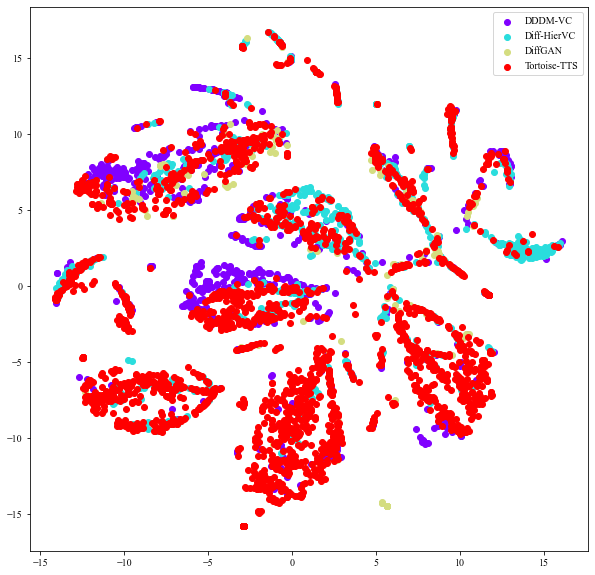

In [52]:
# Keep only Tortoise-TTS and VITS-TTS
tmp_df = merged_df[merged_df["group"].isin(["DDDM-VC", "Tortoise-TTS", "DiffGAN", "Diff-HierVC"])]
# visualize the t-SNE plot of the features
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(tmp_df["feat"].values))

# show color as the group
group = tmp_df["group"].values

# visualize the t-SNE plot
plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(group))))
for i, g in enumerate(np.unique(group)):
    plt.scatter(tsne_results[group == g, 0], tsne_results[group == g, 1], color=colors[i], label=g)
plt.legend()
plt.show()


/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13800 samples in 0.002s...
[t-SNE] Computed neighbors for 13800 samples in 10.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13800
[t-SNE] Computed conditional probabilities for sample 2000 / 13800
[t-SNE] Computed conditional probabilities for sample 3000 / 13800
[t-SNE] Computed conditional probabilities for sample 4000 / 13800
[t-SNE] Computed conditional probabilities for sample 5000 / 13800
[t-SNE] Computed conditional probabilities for sample 6000 / 13800
[t-SNE] Computed conditional probabilities for sample 7000 / 13800
[t-SNE] Computed conditional probabilities for sample 8000 / 13800
[t-SNE] Computed conditional probabilities for sample 9000 / 13800
[t-SNE] Computed conditional probabilities for sample 10000 / 13800
[t-SNE] Computed conditional probabilities for sample 11000 / 13800
[t-SNE] Computed conditional probabilities for sample 12000 / 13800
[t-SNE] Computed conditional probabilities for s

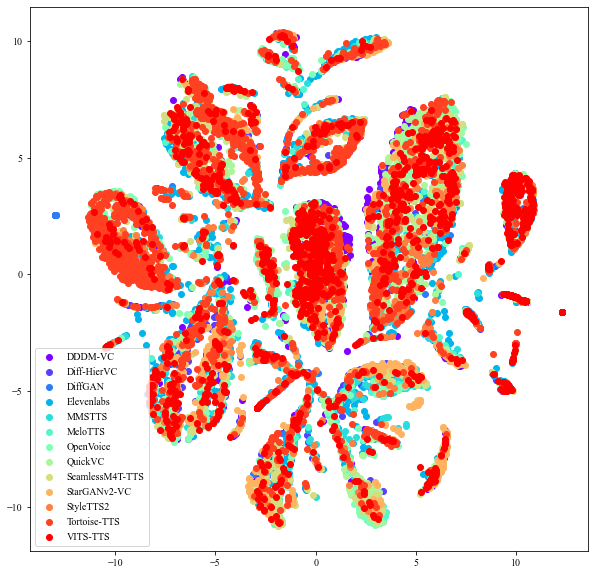

In [43]:
# visualize the t-SNE plot of the features
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(merged_df["feat"].values))

# show color as the group
group = merged_df["group"].values

# visualize the t-SNE plot
plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(group))))
for i, g in enumerate(np.unique(group)):
    plt.scatter(tsne_results[group == g, 0], tsne_results[group == g, 1], color=colors[i], label=g)
plt.legend()
plt.show()


/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13800 samples in 0.003s...
[t-SNE] Computed neighbors for 13800 samples in 13.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13800
[t-SNE] Computed conditional probabilities for sample 2000 / 13800
[t-SNE] Computed conditional probabilities for sample 3000 / 13800
[t-SNE] Computed conditional probabilities for sample 4000 / 13800
[t-SNE] Computed conditional probabilities for sample 5000 / 13800
[t-SNE] Computed conditional probabilities for sample 6000 / 13800
[t-SNE] Computed conditional probabilities for sample 7000 / 13800
[t-SNE] Computed conditional probabilities for sample 8000 / 13800
[t-SNE] Computed conditional probabilities for sample 9000 / 13800
[t-SNE] Computed conditional probabilities for sample 10000 / 13800
[t-SNE] Computed conditional probabilities for sample 11000 / 13800
[t-SNE] Computed conditional probabilities for sample 12000 / 13800
[t-SNE] Computed conditional probabilities for s

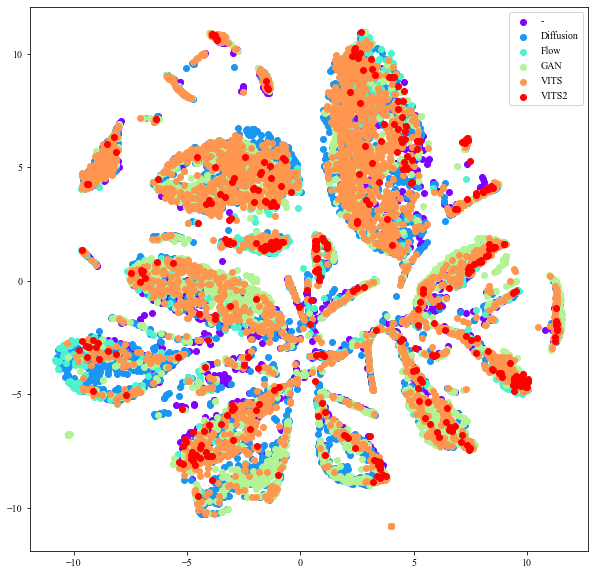

In [44]:
# visualize the t-SNE plot of the features
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(merged_df["feat"].values))

# show color as the group
group = merged_df["Speakers"].values

# visualize the t-SNE plot
plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(group))))
for i, g in enumerate(np.unique(group)):
    plt.scatter(tsne_results[group == g, 0], tsne_results[group == g, 1], color=colors[i], label=g)
plt.legend()
plt.show()


/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phucdt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6867 samples in 0.002s...
[t-SNE] Computed neighbors for 6867 samples in 15.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6867
[t-SNE] Computed conditional probabilities for sample 2000 / 6867
[t-SNE] Computed conditional probabilities for sample 3000 / 6867
[t-SNE] Computed conditional probabilities for sample 4000 / 6867
[t-SNE] Computed conditional probabilities for sample 5000 / 6867
[t-SNE] Computed conditional probabilities for sample 6000 / 6867
[t-SNE] Computed conditional probabilities for sample 6867 / 6867
[t-SNE] Mean sigma: 0.202008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.239990
[t-SNE] KL divergence after 300 iterations: 1.918815


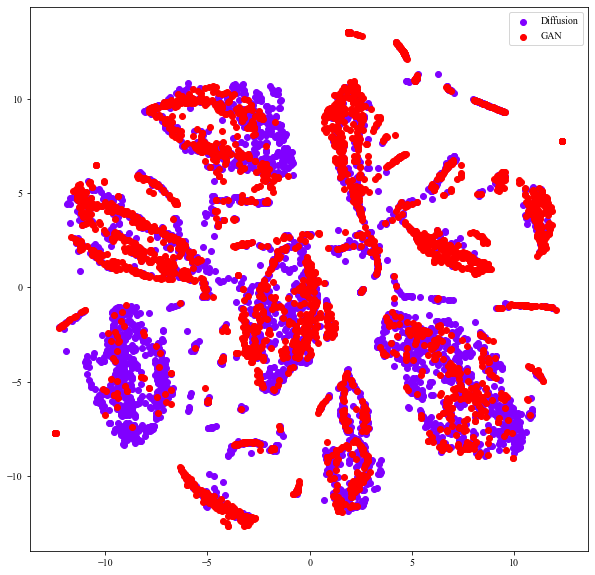

In [45]:
# Keep the Model is "GAN" and "Diffusion"
merged_df = merged_df[merged_df["Model"].isin(["GAN", "Diffusion"])]
# visualize the t-SNE plot of the features
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(merged_df["feat"].values))

# show color as the group
group = merged_df["Model"].values

# visualize the t-SNE plot
plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(group))))
for i, g in enumerate(np.unique(group)):
    plt.scatter(tsne_results[group == g, 0], tsne_results[group == g, 1], color=colors[i], label=g)
plt.legend()
plt.show()


## Family v2

### Flow acoustic

In [3]:
# full_e2egan_epoch17.txt
# pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_flowacoustic_epoch29.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_flowacoustic_new_epoch26.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
flowacoustic_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    flowacoustic_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100

print(flowacoustic_df)

Max, Min score:  3.1546847820281982 -2.134727954864502
Accuracy: 67.98%
Recall: 35.91%
Precision: 99.59%
F1: 52.78%
{'AIHUB': 100.0, 'LibriSpeech': 99.84939759036145, 'VCTK': 99.7362385321101, 'Elevenlabs': 3.225, 'DDDM-VC': 0.0625, 'MeloTTS': 18.625, 'VITS-TTS': 99.60365853658537, 'SeamlessM4T-TTS': 19.43181818181818, 'MMSTTS': 5.347222222222222, 'DiffGAN': 37.0, 'QuickVC': 100.0, 'Diff-HierVC': 73.8125, 'Tortoise-TTS': 31.854166666666668, 'StarGANv2-VC': 88.0, 'OpenVoice': 0.2403846153846154, 'StyleTTS2': 0.2884615384615385, 'SNS2024': 95.23121387283237, 'SNS2023': 51.13636363636363, 'VITS-AIHUB': 21.965317919075144}


### libritts

In [4]:
# full_e2egan_epoch17.txt
# pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_libritts_epoch27.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_libritts_new_epoch14.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
libritts_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    libritts_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100

print(libritts_df)

Max, Min score:  2.5072343349456787 -1.495720624923706
Accuracy: 58.15%
Recall: 16.32%
Precision: 98.43%
F1: 28.00%
{'AIHUB': 100.0, 'LibriSpeech': 99.66114457831326, 'VCTK': 99.55275229357798, 'Elevenlabs': 0.025, 'DDDM-VC': 100.0, 'MeloTTS': 0.0, 'VITS-TTS': 1.676829268292683, 'SeamlessM4T-TTS': 0.3409090909090909, 'MMSTTS': 0.6944444444444444, 'DiffGAN': 0.25, 'QuickVC': 0.5416666666666667, 'Diff-HierVC': 100.0, 'Tortoise-TTS': 6.645833333333333, 'StarGANv2-VC': 98.79166666666667, 'OpenVoice': 0.0, 'StyleTTS2': 0.0, 'SNS2024': 95.01445086705202, 'SNS2023': 50.63920454545454, 'VITS-AIHUB': 0.2477291494632535}


### VCTK

In [5]:
# full_e2egan_epoch17.txt
# pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_vctk_epoch17.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/full_vctk_new_epoch14.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
vctk_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    vctk_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100

print(vctk_df)

Max, Min score:  2.478792667388916 -1.3708436489105225
Accuracy: 60.80%
Recall: 21.40%
Precision: 99.82%
F1: 35.24%
{'AIHUB': 100.0, 'LibriSpeech': 99.97740963855422, 'VCTK': 99.88532110091744, 'Elevenlabs': 0.0, 'DDDM-VC': 1.1875, 'MeloTTS': 0.625, 'VITS-TTS': 35.18292682926829, 'SeamlessM4T-TTS': 3.0113636363636362, 'MMSTTS': 0.7638888888888888, 'DiffGAN': 0.0, 'QuickVC': 99.95833333333334, 'Diff-HierVC': 93.6875, 'Tortoise-TTS': 6.854166666666667, 'StarGANv2-VC': 100.0, 'OpenVoice': 0.09615384615384616, 'StyleTTS2': 0.0, 'SNS2024': 95.23121387283237, 'SNS2023': 50.28409090909091, 'VITS-AIHUB': 0.12976288781408518}


### e2e family

In [6]:
# full_e2egan_epoch17.txt
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_e2egan_epoch17.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_e2egan_epoch26.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
e2egan_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    e2egan_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100

print(e2egan_df)

Max, Min score:  3.0695137977600098 -2.0050740242004395
Accuracy: 70.97%
Recall: 42.11%
Precision: 99.21%
F1: 59.13%
{'AIHUB': 100.0, 'LibriSpeech': 99.8343373493976, 'VCTK': 99.95412844036697, 'Elevenlabs': 92.675, 'DDDM-VC': 0.375, 'MeloTTS': 58.75, 'VITS-TTS': 8.414634146341465, 'SeamlessM4T-TTS': 100.0, 'MMSTTS': 99.51388888888889, 'DiffGAN': 1.0, 'QuickVC': 0.20833333333333334, 'Diff-HierVC': 13.5, 'Tortoise-TTS': 26.625, 'StarGANv2-VC': 10.916666666666666, 'OpenVoice': 24.134615384615383, 'StyleTTS2': 8.365384615384615, 'SNS2024': 95.88150289017341, 'SNS2023': 55.46875, 'VITS-AIHUB': 62.85242420667689}


### Diffusion acoustic

In [7]:
# full_diffacoustic_epoch33.txt
# pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_diffacoustic_epoch33.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_diffacoustic_new_epoch21.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
diffacoustic_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    diffacoustic_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100
print(diffacoustic_df)

Max, Min score:  2.716168165206909 -1.94854748249054
Accuracy: 66.84%
Recall: 33.97%
Precision: 98.57%
F1: 50.52%
{'AIHUB': 100.0, 'LibriSpeech': 99.00602409638554, 'VCTK': 99.9197247706422, 'Elevenlabs': 6.550000000000001, 'DDDM-VC': 100.0, 'MeloTTS': 26.75, 'VITS-TTS': 13.719512195121952, 'SeamlessM4T-TTS': 37.5, 'MMSTTS': 7.291666666666667, 'DiffGAN': 33.75, 'QuickVC': 0.9583333333333333, 'Diff-HierVC': 97.0, 'Tortoise-TTS': 99.6875, 'StarGANv2-VC': 98.58333333333333, 'OpenVoice': 5.288461538461538, 'StyleTTS2': 9.519230769230768, 'SNS2024': 94.94219653179191, 'SNS2023': 50.28409090909091, 'VITS-AIHUB': 1.3448153828005192}


### Ganvoco

In [8]:
# full_ganvoco_epoch46.txt
# pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_ganvoco_epoch46.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_ganvoco_new_epoch24.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
ganvoco_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    ganvoco_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100
print(ganvoco_df)

Max, Min score:  2.9192991256713867 -2.0506298542022705
Accuracy: 75.54%
Recall: 51.26%
Precision: 99.36%
F1: 67.63%
{'AIHUB': 100.0, 'LibriSpeech': 99.60843373493977, 'VCTK': 99.63302752293578, 'Elevenlabs': 8.924999999999999, 'DDDM-VC': 100.0, 'MeloTTS': 19.375, 'VITS-TTS': 99.39024390243902, 'SeamlessM4T-TTS': 34.94318181818182, 'MMSTTS': 3.4722222222222223, 'DiffGAN': 70.75, 'QuickVC': 2.9583333333333335, 'Diff-HierVC': 99.0, 'Tortoise-TTS': 61.68749999999999, 'StarGANv2-VC': 99.66666666666667, 'OpenVoice': 1.7788461538461537, 'StyleTTS2': 0.2884615384615385, 'SNS2024': 95.08670520231213, 'SNS2023': 51.98863636363637, 'VITS-AIHUB': 64.36239235578624}


### GANnoe2e

In [9]:

# full_ganvoco_epoch46.txt
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_gannoe2e_epoch18.txt", sep=" ", header=None)
pred_df = pd.read_csv("/dataa/phucdt/SSL_Anti-spoofing/res/full_gannoe2e_new_epoch11.txt", sep=" ", header=None)

pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('.')[0].split('/')[-1])
print("Max, Min score: ", max(pred_df['score']), min(pred_df['score']))
# print(pred_df.head)
# merge eval_df and pred_df on utt
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# print accuracy
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
# plt.show()

# accuracy grouped by group
ganno2e_df = {}
groups = res_df['group'].unique()
for group in groups:
    group_df = res_df[res_df['group'] == group]
    ganno2e_df[group] = accuracy_score(group_df["label"], group_df["pred"])*100
print(ganno2e_df)

Max, Min score:  2.336488008499145 -1.2803667783737185
Accuracy: 58.53%
Recall: 16.88%
Precision: 99.57%
F1: 28.87%
{'AIHUB': 100.0, 'LibriSpeech': 99.84939759036145, 'VCTK': 99.93119266055047, 'Elevenlabs': 0.025, 'DDDM-VC': 100.0, 'MeloTTS': 0.0, 'VITS-TTS': 2.0121951219512195, 'SeamlessM4T-TTS': 2.3863636363636367, 'MMSTTS': 0.4861111111111111, 'DiffGAN': 0.0, 'QuickVC': 0.5833333333333334, 'Diff-HierVC': 100.0, 'Tortoise-TTS': 9.25, 'StarGANv2-VC': 100.0, 'OpenVoice': 0.09615384615384616, 'StyleTTS2': 0.0, 'SNS2024': 95.08670520231213, 'SNS2023': 50.92329545454546, 'VITS-AIHUB': 0.4010852896071723}


### result analysis

In [11]:


# concat all the results and put to pandas dataframe
all_df = pd.DataFrame([ganno2e_df, e2egan_df, ganno2e_df, diffacoustic_df, flowacoustic_df, ganvoco_df, vctk_df, libritts_df]).T
all_df.columns = ["2GAN", "E2EGAN", "GAN NoE2E", "Diffusion Acoustic", "Flow Acoustic", "GAN Vocoder", "VCTK", "LibriTTS"]
# all_df.to_csv("familyv2_result.csv")
all_df


,2GAN,E2EGAN,GAN NoE2E,Diffusion Acoustic,Flow Acoustic,GAN Vocoder,VCTK,LibriTTS
AIHUB,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
LibriSpeech,99.849398,99.834337,99.849398,99.006024,99.849398,99.608434,99.977410,99.661145
VCTK,99.931193,99.954128,99.931193,99.919725,99.736239,99.633028,99.885321,99.552752
Elevenlabs,0.025000,92.675000,0.025000,6.550000,3.225000,8.925000,0.000000,0.025000
DDDM-VC,100.000000,0.375000,100.000000,100.000000,0.062500,100.000000,1.187500,100.000000
MeloTTS,0.000000,58.750000,0.000000,26.750000,18.625000,19.375000,0.625000,0.000000
VITS-TTS,2.012195,8.414634,2.012195,13.719512,99.603659,99.390244,35.182927,1.676829
SeamlessM4T-TTS,2.386364,100.000000,2.386364,37.500000,19.431818,34.943182,3.011364,0.340909
MMSTTS,0.486111,99.513889,0.486111,7.291667,5.347222,3.472222,0.763889,0.694444
DiffGAN,0.000000,1.000000,0.000000,33.750000,37.000000,70.750000,0.000000,0.250000


## all fake families

In [3]:
score_filelist = os.listdir('./docs/families/')
print(score_filelist)

['Tortoise-TTS_epoch20.txt', 'elevenlabs_epoch22.txt', 'SeamlessM4T-TTS_epoch16.txt', 'Elevenlabs_epoch22.txt', 'trainset_ACMCCS_eval_on_ACMCCS_gan_full_best_checkpoint_27.txt', 'MMSTTS_epoch31.txt', 'tortoise_epoch20.txt', 'Diff-HierVC_epoch16.txt', 'DDDM-VC_epoch32.txt', 'StyleTTS2_epoch24.txt', 'vitstts_epoch36.txt', 'styletts_epoch24.txt', 'VITS-TTS_epoch36.txt', 'DiffGAN_epoch40.txt', 'OpenVoice_epoch20.txt', 'diffhiervc_epoch16.txt', 'melotts_epoch55.txt', 'openvoice_epoch20.txt', 'MeloTTS_epoch55.txt', 'onlyfake_df.csv', 'mmstts_epoch31.txt', 'VITS-VC_epoch15.txt', 'diffgan_epoch40.txt', 'vitsvc_epoch15.txt', 'trainset_ACMCCS_eval_on_ACMCCS_diff_full_best_checkpoint_30.txt', 'final_df.csv', 'trainset_ACMCCS_eval_on_ACMCCS_e2e_full_best_checkpoint_35.txt', 'seamlessm4t_epoch16.txt', 'dddm_epoch32.txt', 'stargan_epoch14.txt', 'StarGANv2-VC_epoch14.txt']


In [13]:
['trainset']+list(acmccs_apr3_df['group'].unique())

['trainset',
 'AIHUB',
 'LibriSpeech',
 'VCTK',
 'Elevenlabs',
 'DDDM-VC',
 'MeloTTS',
 'VITS-TTS',
 'SeamlessM4T-TTS',
 'MMSTTS',
 'DiffGAN',
 'VITS-VC',
 'Diff-HierVC',
 'Tortoise-TTS',
 'StarGANv2-VC',
 'OpenVoice',
 'StyleTTS2',
 'SNS2024',
 'SNS2023',
 'VITS-AIHUB']

In [14]:
len([filter]+[0.0]*len(acmccs_apr3_df['group'].unique()))

20

In [15]:
final_df = pd.DataFrame(columns=['trainset']+list(acmccs_apr3_df['group'].unique()))
for score_file in tqdm(score_filelist):
    trainset = score_file.split('_')[0]
    print(trainset)
    # initialize the coresponding row, trainset is the trainset
    final_df.loc[len(final_df)] = [trainset]+[0]*len(acmccs_apr3_df['group'].unique())
    pred_df = pd.read_csv('./docs/families/'+score_file, sep=' ', header=None)
    pred_df.columns = ["utt","spoof","score"]

    pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

    # if spoof < score, then bonafide, else spoof
    pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

    # merge eval_df and pred_df on utt
    res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
    print(len(res_df))
    # print("False Positive") 
    filter = 'group'
    groups = res_df['group'].unique()
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==trainset, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        
    # print("False negative")
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==filter, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        

  0%|          | 0/31 [00:00<?, ?it/s]

Tortoise-TTS


64090


  3%|▎         | 1/31 [00:02<01:05,  2.18s/it]

elevenlabs
65690


  6%|▋         | 2/31 [00:04<01:02,  2.16s/it]

SeamlessM4T-TTS
70170


 10%|▉         | 3/31 [00:06<00:59,  2.14s/it]

Elevenlabs
65690


 13%|█▎        | 4/31 [00:08<00:53,  1.97s/it]

trainset
74227


 16%|█▌        | 5/31 [00:10<00:51,  1.96s/it]

MMSTTS
70810


 19%|█▉        | 6/31 [00:11<00:45,  1.83s/it]

tortoise
64090


 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]

Diff-HierVC
70490


 26%|██▌       | 8/31 [00:15<00:42,  1.83s/it]

DDDM-VC
70490


 29%|██▉       | 9/31 [00:17<00:42,  1.94s/it]

StyleTTS2
71610


 32%|███▏      | 10/31 [00:19<00:41,  1.96s/it]

vitstts
67130


 35%|███▌      | 11/31 [00:21<00:40,  2.02s/it]

styletts
71610


 39%|███▊      | 12/31 [00:24<00:40,  2.14s/it]

VITS-TTS
67130


 42%|████▏     | 13/31 [00:26<00:37,  2.06s/it]

DiffGAN
72890


 45%|████▌     | 14/31 [00:28<00:35,  2.06s/it]

OpenVoice
69530


 48%|████▊     | 15/31 [00:30<00:32,  2.04s/it]

diffhiervc
70490


 52%|█████▏    | 16/31 [00:32<00:32,  2.17s/it]

melotts
72090


 55%|█████▍    | 17/31 [00:35<00:31,  2.28s/it]

openvoice
69530


 58%|█████▊    | 18/31 [00:37<00:29,  2.27s/it]

MeloTTS
72090


 61%|██████▏   | 19/31 [00:39<00:24,  2.06s/it]


onlyfake


ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [5]:
# final_df.drop(columns=['AIHUB', 'LibriSpeech', 'VCTK', 'SNS2023', 'SNS2024'], inplace=True)
# final_df.to_csv('final_df.csv', index=False)
final_df = pd.read_csv('docs/families/final_df.csv')
final_df

,trainset,AIHUB,LibriSpeech,VCTK,Elevenlabs,DDDM-VC,MeloTTS,VITS-TTS,SeamlessM4T-TTS,MMSTTS,DiffGAN,VITS-VC,Diff-HierVC,Tortoise-TTS,StarGANv2-VC,OpenVoice,StyleTTS2,SNS2024,SNS2023
0,MeloTTS,28.256144,0.0,0.0,28.075,100.0000,0.000,86.951220,9.772727,79.791667,89.00,100.000000,97.3125,55.895833,98.291667,78.846154,87.019231,3.566122,40.719424
1,VITS-VC,41.110572,0.0,0.0,100.000,100.0000,100.000,100.000000,100.000000,100.000000,100.00,0.000000,100.0000,99.875000,99.833333,100.000000,100.000000,5.255023,51.584377
2,Diff-HierVC,40.537825,0.0,0.0,100.000,98.6250,100.000,91.646341,99.659091,100.000000,100.00,99.958333,0.0000,97.645833,2.791667,100.000000,100.000000,5.135952,50.400000
3,OpenVoice,40.220957,0.0,0.0,100.000,100.0000,89.625,100.000000,100.000000,100.000000,80.50,100.000000,100.0000,99.875000,100.000000,0.000000,99.807692,5.226749,50.879765
4,MMSTTS,36.609571,0.0,0.0,44.225,99.5625,73.500,99.908537,43.750000,0.000000,99.75,99.958333,99.2500,92.020833,100.000000,91.923077,91.346154,4.518072,42.597968
5,Elevenlabs,19.683664,0.0,0.0,0.000,99.9375,27.875,73.536585,0.738636,69.861111,94.50,100.000000,95.6875,54.750000,92.041667,91.298077,95.192308,4.038772,42.319277
6,Tortoise-TTS,42.886775,0.0,0.0,97.625,94.1250,82.000,91.676829,88.806818,99.652778,78.25,99.958333,49.8125,0.000000,26.500000,98.076923,97.596154,5.189456,53.012967
7,StarGANv2-VC,41.008729,0.0,0.0,100.000,97.4375,99.875,80.731707,97.159091,100.000000,100.00,99.958333,1.6875,90.687500,0.000000,100.000000,100.000000,5.023184,51.289609
8,DiffGAN,39.486289,0.0,0.0,99.925,100.0000,100.000,97.560976,99.943182,100.000000,0.00,100.000000,99.9375,93.583333,100.000000,100.000000,99.038462,4.797048,34.025788
9,StyleTTS2,40.184878,0.0,0.0,99.450,100.0000,88.625,99.939024,100.000000,97.013889,98.50,100.000000,99.9375,93.333333,100.000000,100.000000,0.000000,5.074627,50.217077


In [6]:
# final_df
first_col = final_df.pop('trainset')
# change the order of the columns
first_col = first_col.tolist()
final_df = final_df.reindex(sorted(final_df.columns), axis=1)
# change to accuracy by change all cells to 100 - cell
final_df = 100 - final_df


# add the first column back
final_df.insert(0, 'trainset', first_col)
final_df

,trainset,AIHUB,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,LibriSpeech,MMSTTS,MeloTTS,OpenVoice,SNS2023,SNS2024,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VCTK,VITS-TTS,VITS-VC
0,MeloTTS,71.743856,0.0000,2.6875,11.00,71.925,100.0,20.208333,100.000,21.153846,59.280576,96.433878,90.227273,1.708333,12.980769,44.104167,100.0,13.048780,0.000000
1,VITS-VC,58.889428,0.0000,0.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,48.415623,94.744977,0.000000,0.166667,0.000000,0.125000,100.0,0.000000,100.000000
2,Diff-HierVC,59.462175,1.3750,100.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,49.600000,94.864048,0.340909,97.208333,0.000000,2.354167,100.0,8.353659,0.041667
3,OpenVoice,59.779043,0.0000,0.0000,19.50,0.000,100.0,0.000000,10.375,100.000000,49.120235,94.773251,0.000000,0.000000,0.192308,0.125000,100.0,0.000000,0.000000
4,MMSTTS,63.390429,0.4375,0.7500,0.25,55.775,100.0,100.000000,26.500,8.076923,57.402032,95.481928,56.250000,0.000000,8.653846,7.979167,100.0,0.091463,0.041667
5,Elevenlabs,80.316336,0.0625,4.3125,5.50,100.000,100.0,30.138889,72.125,8.701923,57.680723,95.961228,99.261364,7.958333,4.807692,45.250000,100.0,26.463415,0.000000
6,Tortoise-TTS,57.113225,5.8750,50.1875,21.75,2.375,100.0,0.347222,18.000,1.923077,46.987033,94.810544,11.193182,73.500000,2.403846,100.000000,100.0,8.323171,0.041667
7,StarGANv2-VC,58.991271,2.5625,98.3125,0.00,0.000,100.0,0.000000,0.125,0.000000,48.710391,94.976816,2.840909,100.000000,0.000000,9.312500,100.0,19.268293,0.041667
8,DiffGAN,60.513711,0.0000,0.0625,100.00,0.075,100.0,0.000000,0.000,0.000000,65.974212,95.202952,0.056818,0.000000,0.961538,6.416667,100.0,2.439024,0.000000
9,StyleTTS2,59.815122,0.0000,0.0625,1.50,0.550,100.0,2.986111,11.375,0.000000,49.782923,94.925373,0.000000,0.000000,100.000000,6.666667,100.0,0.060976,0.000000


In [7]:
#sort the row based on the trainset
final_df = final_df.sort_values(by='trainset')
final_df

,trainset,AIHUB,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,LibriSpeech,MMSTTS,MeloTTS,OpenVoice,SNS2023,SNS2024,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VCTK,VITS-TTS,VITS-VC
11,DDDM-VC,59.438251,100.0000,16.9375,20.50,0.000,100.0,0.138889,0.000,0.000000,50.545455,94.864048,0.000000,5.333333,0.000000,0.437500,100.0,0.000000,0.416667
2,Diff-HierVC,59.462175,1.3750,100.0000,0.00,0.000,100.0,0.000000,0.000,0.000000,49.600000,94.864048,0.340909,97.208333,0.000000,2.354167,100.0,8.353659,0.041667
8,DiffGAN,60.513711,0.0000,0.0625,100.00,0.075,100.0,0.000000,0.000,0.000000,65.974212,95.202952,0.056818,0.000000,0.961538,6.416667,100.0,2.439024,0.000000
5,Elevenlabs,80.316336,0.0625,4.3125,5.50,100.000,100.0,30.138889,72.125,8.701923,57.680723,95.961228,99.261364,7.958333,4.807692,45.250000,100.0,26.463415,0.000000
4,MMSTTS,63.390429,0.4375,0.7500,0.25,55.775,100.0,100.000000,26.500,8.076923,57.402032,95.481928,56.250000,0.000000,8.653846,7.979167,100.0,0.091463,0.041667
0,MeloTTS,71.743856,0.0000,2.6875,11.00,71.925,100.0,20.208333,100.000,21.153846,59.280576,96.433878,90.227273,1.708333,12.980769,44.104167,100.0,13.048780,0.000000
3,OpenVoice,59.779043,0.0000,0.0000,19.50,0.000,100.0,0.000000,10.375,100.000000,49.120235,94.773251,0.000000,0.000000,0.192308,0.125000,100.0,0.000000,0.000000
10,SeamlessM4T-TTS,68.123591,0.0625,8.2500,0.00,65.775,100.0,13.888889,60.750,0.144231,57.580175,95.579268,100.000000,9.750000,0.192308,14.270833,100.0,4.420732,0.041667
7,StarGANv2-VC,58.991271,2.5625,98.3125,0.00,0.000,100.0,0.000000,0.125,0.000000,48.710391,94.976816,2.840909,100.000000,0.000000,9.312500,100.0,19.268293,0.041667
9,StyleTTS2,59.815122,0.0000,0.0625,1.50,0.550,100.0,2.986111,11.375,0.000000,49.782923,94.925373,0.000000,0.000000,100.000000,6.666667,100.0,0.060976,0.000000


In [8]:
final_df.drop(columns=['AIHUB', 'LibriSpeech', 'VCTK', 'SNS2023', 'SNS2024'], inplace=True)
final_df

,trainset,DDDM-VC,Diff-HierVC,DiffGAN,Elevenlabs,MMSTTS,MeloTTS,OpenVoice,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VITS-TTS,VITS-VC
11,DDDM-VC,100.0000,16.9375,20.50,0.000,0.138889,0.000,0.000000,0.000000,5.333333,0.000000,0.437500,0.000000,0.416667
2,Diff-HierVC,1.3750,100.0000,0.00,0.000,0.000000,0.000,0.000000,0.340909,97.208333,0.000000,2.354167,8.353659,0.041667
8,DiffGAN,0.0000,0.0625,100.00,0.075,0.000000,0.000,0.000000,0.056818,0.000000,0.961538,6.416667,2.439024,0.000000
5,Elevenlabs,0.0625,4.3125,5.50,100.000,30.138889,72.125,8.701923,99.261364,7.958333,4.807692,45.250000,26.463415,0.000000
4,MMSTTS,0.4375,0.7500,0.25,55.775,100.000000,26.500,8.076923,56.250000,0.000000,8.653846,7.979167,0.091463,0.041667
0,MeloTTS,0.0000,2.6875,11.00,71.925,20.208333,100.000,21.153846,90.227273,1.708333,12.980769,44.104167,13.048780,0.000000
3,OpenVoice,0.0000,0.0000,19.50,0.000,0.000000,10.375,100.000000,0.000000,0.000000,0.192308,0.125000,0.000000,0.000000
10,SeamlessM4T-TTS,0.0625,8.2500,0.00,65.775,13.888889,60.750,0.144231,100.000000,9.750000,0.192308,14.270833,4.420732,0.041667
7,StarGANv2-VC,2.5625,98.3125,0.00,0.000,0.000000,0.125,0.000000,2.840909,100.000000,0.000000,9.312500,19.268293,0.041667
9,StyleTTS2,0.0000,0.0625,1.50,0.550,2.986111,11.375,0.000000,0.000000,0.000000,100.000000,6.666667,0.060976,0.000000


In [118]:
final_df.to_csv('onlyfake_df.csv')

### visualize

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


<Figure size 2520x2160 with 0 Axes>

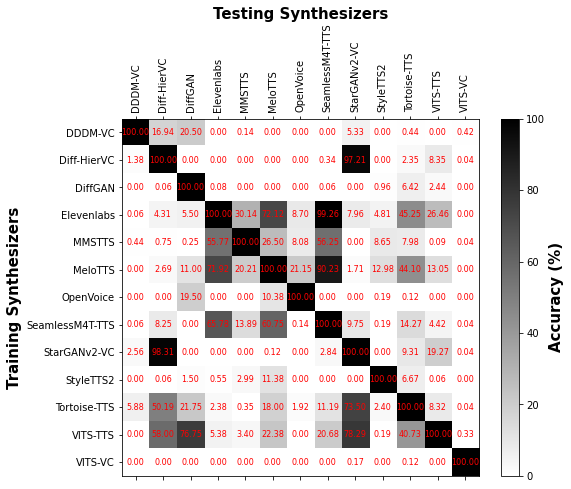

In [10]:
# visulize the data, higher value, darker color
final_df = pd.read_csv('docs/families/onlyfake_df.csv')

plt.figure(figsize=(35,30))

# set font is "Time New Roman"
plt.rcParams["font.family"] = "Times New Roman"

plt.matshow(final_df.iloc[:,1:], cmap='binary')
# add the labels also
plt.xticks(range(final_df.shape[1]-1), final_df.columns[1:], rotation=90)
plt.yticks(range(final_df.shape[0]), final_df['trainset'])
# plt.colorbar()
# x-axis labels
plt.xlabel('Testing Synthesizers', fontsize=15, weight='bold')

# set colorbar size
plt.colorbar(shrink=0.8).set_label('Accuracy (%)', fontsize=15, weight='bold')
# x-axis labels on the top
plt.gca().xaxis.set_label_position('top')
# y-axis labels
plt.ylabel('Training Synthesizers', fontsize=15, weight='bold')

# put the values on the cells
for i in range(final_df.shape[0]):
    for j in range(final_df.shape[1]-1):
        plt.text(j, i, "{:.2f}".format(final_df.iloc[i,j+1]), ha='center', va='center', color='red', fontsize=8)


#extend the margin of the figure to not lose the labels
# plt.subplots_adjust(left=0., right=0.9, top=0.9, bottom=0.1)

# increase the cell size
plt.gcf().set_size_inches(8, 8)

# save the image
plt.savefig('figs/onlyfake_df.pdf',format="pdf", bbox_inches='tight')




### families/dddm_epoch32.txt

70490
70490
70490
Max, Min score:  2.1393930912017822 -1.2625943422317505
False Positive
AIHUB - 8477 - 40.5617%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 4000 - 100.0000%
MeloTTS - 800 - 100.0000%
VITS-TTS - 3280 - 100.0000%
SeamlessM4T-TTS - 1760 - 100.0000%
MMSTTS - 1438 - 99.8611%
DiffGAN - 318 - 79.5000%
VITS-VC - 2390 - 99.5833%
Diff-HierVC - 1329 - 83.0625%
Tortoise-TTS - 4779 - 99.5625%
StarGANv2-VC - 2272 - 94.6667%
OpenVoice - 2080 - 100.0000%
StyleTTS2 - 1040 - 100.0000%
SNS2024 - 68 - 5.1360%
SNS2023 - 680 - 49.4545%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 40 - 0.3174%
VCTK - 8 - 0.0965%
Elevenlabs - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 0 - 0.0000%
SNS2023 - 13 - 0.9455%
Accuracy: 50.6710%


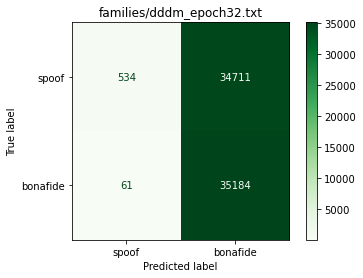

In [9]:
pred_df = pd.read_csv("families/dddm_epoch32.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/dddm_epoch32.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/diffgan_epoch40.txt

In [ ]:
pred_df = pd.read_csv("families/dddm_epoch32.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/dddm_epoch32.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/stargan_epoch14.txt

68890
68890
68890
Max, Min score:  2.4354443550109863 -1.309525728225708
False Positive
AIHUB - 8456 - 41.0087%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 4000 - 100.0000%
DDDM-VC - 1559 - 97.4375%
MeloTTS - 799 - 99.8750%
VITS-TTS - 2648 - 80.7317%
SeamlessM4T-TTS - 1710 - 97.1591%
MMSTTS - 1440 - 100.0000%
DiffGAN - 400 - 100.0000%
VITS-VC - 2399 - 99.9583%
Diff-HierVC - 27 - 1.6875%
Tortoise-TTS - 4353 - 90.6875%
OpenVoice - 2080 - 100.0000%
StyleTTS2 - 1040 - 100.0000%
SNS2024 - 65 - 5.0232%
SNS2023 - 696 - 51.2896%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 0 - 0.0000%
SNS2023 - 3 - 0.2211%
Accuracy: 54.0209%


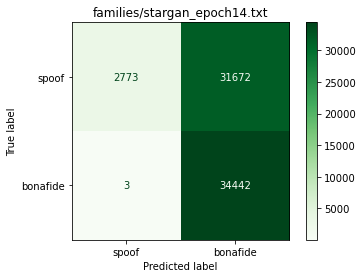

In [5]:
pred_df = pd.read_csv("families/stargan_epoch14.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/stargan_epoch14.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### families/mmstts_epoch31.txt

70810
70810
70810
Max, Min score:  2.532159805297852 -1.4933289289474487
False Positive
AIHUB - 7673 - 36.6096%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 1769 - 44.2250%
DDDM-VC - 1593 - 99.5625%
MeloTTS - 588 - 73.5000%
VITS-TTS - 3277 - 99.9085%
SeamlessM4T-TTS - 770 - 43.7500%
DiffGAN - 399 - 99.7500%
VITS-VC - 2399 - 99.9583%
Diff-HierVC - 1588 - 99.2500%
Tortoise-TTS - 4417 - 92.0208%
StarGANv2-VC - 2400 - 100.0000%
OpenVoice - 1912 - 91.9231%
StyleTTS2 - 950 - 91.3462%
SNS2024 - 60 - 4.5181%
SNS2023 - 587 - 42.5980%
False negative
AIHUB - 2 - 0.0095%
LibriSpeech - 98 - 0.7740%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 13 - 0.9789%
SNS2023 - 151 - 10.9579%
Accuracy: 56.7208%


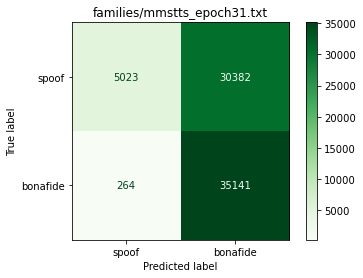

In [7]:
pred_df = pd.read_csv("families/mmstts_epoch31.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("families/mmstts_epoch31.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## Fake families New

In [13]:
score_filelist = os.listdir('/dataa/phucdt/SSL_Anti-spoofing/families_new/')

score_filelist = [x for x in score_filelist if x.endswith('.txt')]
print(score_filelist)

['DDDM-VC_epoch28.txt', 'Diff-HierVC_epoch32.txt', 'SeamlessM4T-TTS_epoch43.txt', 'QuickVC_epoch36.txt', 'Tortoise-TTS_epoch62.txt', 'OpenVoice_epoch46.txt', 'MeloTTS_epoch55.txt', 'StarGANv2-VC_epoch28.txt', 'StyleTTS2_epoch44.txt', 'VITS-TTS_epoch22.txt', 'Elevenlabs_epoch23.txt', 'MMSTTS_epoch30.txt']


In [14]:
['trainset']+list(acmccs_apr3_df['group'].unique())
len([filter]+[0.0]*len(acmccs_apr3_df['group'].unique()))

20

In [15]:
final_df = pd.DataFrame(columns=['trainset']+list(acmccs_apr3_df['group'].unique()))
for score_file in tqdm(score_filelist):
    trainset = score_file.split('_')[0]
    print(trainset)
    # initialize the coresponding row, trainset is the trainset
    final_df.loc[len(final_df)] = [trainset]+[0]*len(acmccs_apr3_df['group'].unique())
    pred_df = pd.read_csv('/dataa/phucdt/SSL_Anti-spoofing/families_new/'+score_file, sep=' ', header=None)
    pred_df.columns = ["utt","spoof","score"]

    pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

    # if spoof < score, then bonafide, else spoof
    pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

    # merge eval_df and pred_df on utt
    res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
    print(len(res_df))
    # print("False Positive") 
    filter = 'group'
    groups = res_df['group'].unique()
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==trainset, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        
    # print("False negative")
    for group in groups:
        num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
        num_total = res_df[res_df[filter]==group].shape[0]
        # update the final_df
        final_df.loc[final_df['trainset']==filter, group] = 100.0 - num_misclass/num_total*100
        # print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
        

  0%|          | 0/12 [00:00<?, ?it/s]

DDDM-VC
70490


  8%|▊         | 1/12 [00:02<00:26,  2.38s/it]

Diff-HierVC
70490


 17%|█▋        | 2/12 [00:04<00:21,  2.20s/it]

SeamlessM4T-TTS
70170


 25%|██▌       | 3/12 [00:06<00:20,  2.27s/it]

QuickVC
68890


 33%|███▎      | 4/12 [00:08<00:17,  2.19s/it]

Tortoise-TTS
64090


 42%|████▏     | 5/12 [00:10<00:14,  2.12s/it]

OpenVoice
69530


 50%|█████     | 6/12 [00:13<00:12,  2.13s/it]

MeloTTS
72090


 58%|█████▊    | 7/12 [00:15<00:10,  2.13s/it]

StarGANv2-VC
68890


 67%|██████▋   | 8/12 [00:17<00:08,  2.17s/it]

StyleTTS2
71610


 75%|███████▌  | 9/12 [00:19<00:06,  2.19s/it]

VITS-TTS
67130


 83%|████████▎ | 10/12 [00:21<00:04,  2.09s/it]

Elevenlabs
65690


 92%|█████████▏| 11/12 [00:23<00:02,  2.02s/it]

MMSTTS
70810


100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


In [16]:
# including diffGAN
final_df

,trainset,AIHUB,LibriSpeech,VCTK,Elevenlabs,DDDM-VC,MeloTTS,VITS-TTS,SeamlessM4T-TTS,MMSTTS,DiffGAN,QuickVC,Diff-HierVC,Tortoise-TTS,StarGANv2-VC,OpenVoice,StyleTTS2,SNS2024,SNS2023,VITS-AIHUB
0,DDDM-VC,100.0,100.0,100.0,0.000,0.0000,0.000,0.030488,0.000000,0.555556,20.50,1.333333,38.6875,1.750000,9.833333,0.000000,0.000000,95.015106,57.018182,0.035390
1,Diff-HierVC,100.0,100.0,100.0,0.150,1.2500,0.000,12.621951,1.363636,0.138889,0.00,0.041667,0.0000,12.062500,96.291667,0.000000,0.000000,95.317221,53.745455,0.943730
2,SeamlessM4T-TTS,100.0,100.0,100.0,67.400,0.0000,58.125,1.798780,0.000000,14.652778,2.25,0.000000,7.1875,17.770833,4.416667,0.000000,0.000000,95.807927,61.370262,30.293736
3,QuickVC,100.0,100.0,100.0,0.000,0.0000,0.000,0.243902,0.000000,0.000000,0.00,0.000000,0.2500,0.145833,0.791667,0.000000,0.000000,94.744977,48.415623,0.000000
4,Tortoise-TTS,100.0,100.0,100.0,9.550,14.0625,39.125,40.853659,19.375000,9.097222,50.75,1.625000,86.6875,0.000000,87.791667,3.461538,36.538462,95.551895,54.919908,0.259526
5,OpenVoice,100.0,100.0,100.0,0.000,0.0000,11.875,0.000000,0.000000,0.138889,21.00,0.000000,0.0000,1.187500,0.000000,0.000000,0.673077,95.157571,56.451613,9.920963
6,MeloTTS,100.0,100.0,100.0,71.925,0.0000,0.000,13.018293,90.227273,20.208333,11.00,0.000000,2.6875,44.104167,1.708333,21.153846,12.980769,96.433878,59.280576,29.444379
7,StarGANv2-VC,100.0,100.0,100.0,0.000,2.8750,0.000,21.554878,3.068182,0.000000,0.00,0.166667,99.1250,8.104167,0.000000,0.000000,0.000000,95.054096,51.215917,0.259526
8,StyleTTS2,100.0,100.0,100.0,3.425,0.0000,29.125,0.396341,0.000000,9.791667,3.75,0.083333,0.0000,24.666667,0.000000,0.048077,0.000000,94.925373,50.144718,0.000000
9,VITS-TTS,100.0,100.0,100.0,23.150,0.2500,28.750,0.000000,34.943182,0.972222,47.00,0.458333,93.9375,67.750000,94.375000,0.000000,1.826923,96.205534,64.307004,85.478353


In [27]:
# Drop columns: ["AIHUB", "LibriSpeech", "VCTK", "SNS2023", "SNS2024", "DiffGAN", "VITS-AIHUB"]
# final_df.drop(columns=["AIHUB", "LibriSpeech", "VCTK", "SNS2023", "SNS2024", "DiffGAN", "VITS-AIHUB"], inplace=True)
# final_df.to_csv('final_df_new.csv', index=False)
final_df = pd.read_csv('final_df_new.csv')
final_df

,trainset,Elevenlabs,DDDM-VC,MeloTTS,VITS-TTS,SeamlessM4T-TTS,MMSTTS,QuickVC,Diff-HierVC,Tortoise-TTS,StarGANv2-VC,OpenVoice,StyleTTS2
0,DDDM-VC,0.000,0.0000,0.000,0.030488,0.000000,0.555556,1.333333,38.6875,1.750000,9.833333,0.000000,0.000000
1,Diff-HierVC,0.150,1.2500,0.000,12.621951,1.363636,0.138889,0.041667,0.0000,12.062500,96.291667,0.000000,0.000000
2,SeamlessM4T-TTS,67.400,0.0000,58.125,1.798780,0.000000,14.652778,0.000000,7.1875,17.770833,4.416667,0.000000,0.000000
3,QuickVC,0.000,0.0000,0.000,0.243902,0.000000,0.000000,0.000000,0.2500,0.145833,0.791667,0.000000,0.000000
4,Tortoise-TTS,9.550,14.0625,39.125,40.853659,19.375000,9.097222,1.625000,86.6875,0.000000,87.791667,3.461538,36.538462
5,OpenVoice,0.000,0.0000,11.875,0.000000,0.000000,0.138889,0.000000,0.0000,1.187500,0.000000,0.000000,0.673077
6,MeloTTS,71.925,0.0000,0.000,13.018293,90.227273,20.208333,0.000000,2.6875,44.104167,1.708333,21.153846,12.980769
7,StarGANv2-VC,0.000,2.8750,0.000,21.554878,3.068182,0.000000,0.166667,99.1250,8.104167,0.000000,0.000000,0.000000
8,StyleTTS2,3.425,0.0000,29.125,0.396341,0.000000,9.791667,0.083333,0.0000,24.666667,0.000000,0.048077,0.000000
9,VITS-TTS,23.150,0.2500,28.750,0.000000,34.943182,0.972222,0.458333,93.9375,67.750000,94.375000,0.000000,1.826923


In [28]:
# set trainset as the index
final_df.set_index('trainset', inplace=True)
# sort table by index
final_df = final_df.sort_index()
# sort the column
final_df = final_df.reindex(sorted(final_df.columns), axis=1)
final_df


,DDDM-VC,Diff-HierVC,Elevenlabs,MMSTTS,MeloTTS,OpenVoice,QuickVC,SeamlessM4T-TTS,StarGANv2-VC,StyleTTS2,Tortoise-TTS,VITS-TTS
trainset,,,,,,,,,,,,
DDDM-VC,0.0000,38.6875,0.000,0.555556,0.000,0.000000,1.333333,0.000000,9.833333,0.000000,1.750000,0.030488
Diff-HierVC,1.2500,0.0000,0.150,0.138889,0.000,0.000000,0.041667,1.363636,96.291667,0.000000,12.062500,12.621951
Elevenlabs,0.0000,17.0625,0.000,62.569444,68.125,1.057692,0.000000,99.034091,12.041667,29.807692,41.687500,17.530488
MMSTTS,0.3125,8.3125,69.050,0.000000,30.000,15.576923,0.041667,79.147727,1.000000,16.057692,16.854167,0.365854
MeloTTS,0.0000,2.6875,71.925,20.208333,0.000,21.153846,0.000000,90.227273,1.708333,12.980769,44.104167,13.018293
OpenVoice,0.0000,0.0000,0.000,0.138889,11.875,0.000000,0.000000,0.000000,0.000000,0.673077,1.187500,0.000000
QuickVC,0.0000,0.2500,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.791667,0.000000,0.145833,0.243902
SeamlessM4T-TTS,0.0000,7.1875,67.400,14.652778,58.125,0.000000,0.000000,0.000000,4.416667,0.000000,17.770833,1.798780
StarGANv2-VC,2.8750,99.1250,0.000,0.000000,0.000,0.000000,0.166667,3.068182,0.000000,0.000000,8.104167,21.554878


In [31]:
# order the columns as: ["StarGANv2-VC", "Diff-HierVC", "DDDM-VC", "Tortoise-TTS", "QuickVC", "VITS-TTS", "StyleTTS2", "OpenVoice" ,"MeloTTS", "MMSTTS", "SeamlessM4T-TTS", "Elevenlabs"]
# order the rows same as the columns
final_df = final_df.reindex(columns=["StarGANv2-VC", "Diff-HierVC", "DDDM-VC", "Tortoise-TTS", "QuickVC", "VITS-TTS", "StyleTTS2", "OpenVoice" ,"MeloTTS", "MMSTTS", "SeamlessM4T-TTS", "Elevenlabs"])
# make the rows as: ["StarGANv2-VC", "Diff-HierVC", "DDDM-VC", "Tortoise-TTS", "QuickVC", "VITS-TTS", "StyleTTS2", "OpenVoice" ,"MeloTTS", "MMSTTS", "SeamlessM4T-TTS", "Elevenlabs"]
final_df = final_df.reindex(index=["StarGANv2-VC", "Diff-HierVC", "DDDM-VC", "Tortoise-TTS", "QuickVC", "VITS-TTS", "StyleTTS2", "OpenVoice" ,"MeloTTS", "MMSTTS", "SeamlessM4T-TTS", "Elevenlabs"])
# final_df
# if the row and column are the same, then the value is 100
for i in range(final_df.shape[0]):
    for j in range(final_df.shape[1]):
        if i == j:
            final_df.iloc[i,j] = 100.0
final_df


,StarGANv2-VC,Diff-HierVC,DDDM-VC,Tortoise-TTS,QuickVC,VITS-TTS,StyleTTS2,OpenVoice,MeloTTS,MMSTTS,SeamlessM4T-TTS,Elevenlabs
trainset,,,,,,,,,,,,
StarGANv2-VC,100.000000,99.1250,2.8750,8.104167,0.166667,21.554878,0.000000,0.000000,0.000,0.000000,3.068182,0.000
Diff-HierVC,96.291667,100.0000,1.2500,12.062500,0.041667,12.621951,0.000000,0.000000,0.000,0.138889,1.363636,0.150
DDDM-VC,9.833333,38.6875,100.0000,1.750000,1.333333,0.030488,0.000000,0.000000,0.000,0.555556,0.000000,0.000
Tortoise-TTS,87.791667,86.6875,14.0625,100.000000,1.625000,40.853659,36.538462,3.461538,39.125,9.097222,19.375000,9.550
QuickVC,0.791667,0.2500,0.0000,0.145833,100.000000,0.243902,0.000000,0.000000,0.000,0.000000,0.000000,0.000
VITS-TTS,94.375000,93.9375,0.2500,67.750000,0.458333,100.000000,1.826923,0.000000,28.750,0.972222,34.943182,23.150
StyleTTS2,0.000000,0.0000,0.0000,24.666667,0.083333,0.396341,100.000000,0.048077,29.125,9.791667,0.000000,3.425
OpenVoice,0.000000,0.0000,0.0000,1.187500,0.000000,0.000000,0.673077,100.000000,11.875,0.138889,0.000000,0.000
MeloTTS,1.708333,2.6875,0.0000,44.104167,0.000000,13.018293,12.980769,21.153846,100.000,20.208333,90.227273,71.925


In [32]:
final_df.to_csv('/dataa/phucdt/SSL_Anti-spoofing/families_new/final_df_new_ordered.csv')

<Figure size 2520x2160 with 0 Axes>

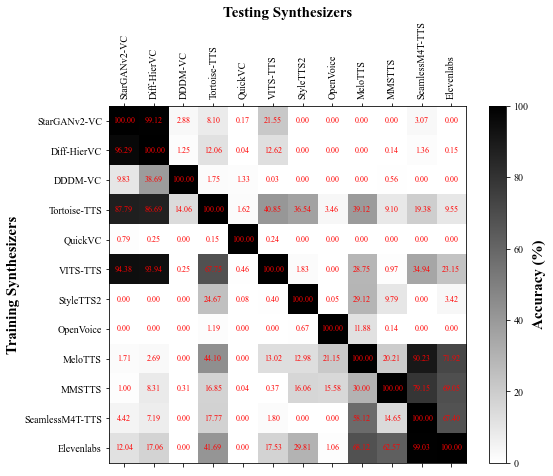

In [34]:
# visualize
# visulize the data, higher value, darker color
final_df = pd.read_csv('/dataa/phucdt/SSL_Anti-spoofing/families_new/final_df_new_ordered.csv')

plt.figure(figsize=(35,30))

# set font is "Time New Roman"
plt.rcParams["font.family"] = "Times New Roman"

plt.matshow(final_df.iloc[:,1:], cmap='binary')
# add the labels also
plt.xticks(range(final_df.shape[1]-1), final_df.columns[1:], rotation=90)
plt.yticks(range(final_df.shape[0]), final_df['trainset'])
# plt.colorbar()
# x-axis labels
plt.xlabel('Testing Synthesizers', fontsize=15, weight='bold', fontname="Times New Roman")

# set colorbar size
plt.colorbar(shrink=0.8).set_label('Accuracy (%)', fontsize=15, weight='bold', fontname="Times New Roman")
# x-axis labels on the top
plt.gca().xaxis.set_label_position('top')
# y-axis labels
plt.ylabel('Training Synthesizers', fontsize=15, weight='bold', fontname="Times New Roman")

# put the values on the cells
for i in range(final_df.shape[0]):
    for j in range(final_df.shape[1]-1):
        plt.text(j, i, "{:.2f}".format(final_df.iloc[i,j+1]), ha='center', va='center', color='red', fontsize=8)


#extend the margin of the figure to not lose the labels
# plt.subplots_adjust(left=0., right=0.9, top=0.9, bottom=0.1)

# increase the cell size
plt.gcf().set_size_inches(8, 8)

# save the image
plt.savefig('figs/onlyfake_df_new.pdf', dpi=600,format="pdf", bbox_inches='tight')




In [12]:
final_df = pd.read_csv('/dataa/phucdt/SSL_Anti-spoofing/families_new/final_df_new_ordered.csv')
final_df
final_df.set_index('trainset', inplace=True)

In [21]:
# 
group1 = ['StarGANv2-VC', 'Diff-HierVC', 'DDDM-VC']
group2 = ['OpenVoice', 'VITS-TTS', 'MeloTTS', 'MMSTTS', 'SeamlessM4T-TTS']
group3 = ['StarGANv2-VC', 'Diff-HierVC']
group4 = ['VITS-TTS', 'MeloTTS', 'MMSTTS', 'SeamlessM4T-TTS']
ungrouped = ['QuickVC', 'StyleTTS2', 'Elevenlabs', 'Tortoise-TTS']
# set trainset as the index

# intra group detection rate average
print("group 1")
for synthesizer in group1:
    mean = final_df.loc[synthesizer, group1].mean()
    print(f'{synthesizer} - {mean}')

print("group 2")
for synthesizer in group2:
    mean = final_df.loc[synthesizer, group2].mean()
    print(f'{synthesizer} - {mean}')

print("group 3")
for synthesizer in group3:
    mean = final_df.loc[synthesizer, group3].mean()
    print(f'{synthesizer} - {mean}')

print("group 4")
for synthesizer in group4:
    mean = final_df.loc[synthesizer, group4].mean()
    print(f'{synthesizer} - {mean}')
    
    
print("ungrouped")
for synthesizer in ungrouped:
    mean = final_df.loc[synthesizer].mean()
    print(f'{synthesizer} - {mean}')

group 1
StarGANv2-VC - 67.33333333333333
Diff-HierVC - 65.84722222222223
DDDM-VC - 49.50694444444445
group 2
OpenVoice - 22.40277777777778
VITS-TTS - 32.93308080808081
MeloTTS - 48.92154897947581
MMSTTS - 45.01810080163739
SeamlessM4T-TTS - 34.91531165311653
group 3
StarGANv2-VC - 99.5625
Diff-HierVC - 98.14583333333334
group 4
VITS-TTS - 41.16635101010101
MeloTTS - 55.86347468588322
MMSTTS - 52.37839523281597
SeamlessM4T-TTS - 43.644139566395665
ungrouped
QuickVC - 8.4526168699187
StyleTTS2 - 13.961340421096518
Elevenlabs - 37.40967287003872
Tortoise-TTS - 37.34729561878952
